<a href="https://colab.research.google.com/github/MinooSdpr/Complex-And-Fractional-Number/blob/master/NLP_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

## Make a copy

**Follow the following steps to make your own copy. You will lose your changes if you don't make your own copy!**

From the tooltip above, you should see 

File | Edit | View | Insert | Runtime | Tools | Help

1. Click on **File**
2. Click on **Save a copy in Drive**

## Import

Let's import the required packages and setup some settings that will help us in this notebook.

In [ ]:
# import the required packages
from fastai.text import *
from fastai.metrics import error_rate
from google.colab import files
import numpy as np
import pandas as pd

# Data

Probably you know IMDb, an online database of Movies information, ratings and reviews. There are tons of comments on this site about every single movie.  This means we have lots of opinions, which means there are lots of works to make everything organaized.
Imagine that we can find out if a review is a positive or negetive one.
For this concept we need to build an NLP system. 
 


Today we are going to train a Natural Language Processing Model to classify IMDb reviews.


> At the end of this session you will be able to write a text and the model will be able to find out does your text have a good feeling or the bad one.


## Looking at data

First things first. Let's download our dataset and put it to `data` variable.
  

In [ ]:
# Download IMDB dataset
path = untar_data(URLs.IMDB_SAMPLE)
data = pd.read_csv(path/'texts.csv')

Here is a sample of our dataset:

In [ ]:
data.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


And this is one of those reviews:

In [ ]:
data['text'][1]

'This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is some merit in this view, but it\'s also true that no one forced Hindus and Muslims in the region to mistreat each other as they did around the time of partition. It seems more likely that the British simply saw the tensions between the religions and were clever enough to exploit them to their own ends.<br /><br />The result is that there is much cruelty and inhumanity in the situation and this is very u

We can use `describe()` method to wrap-up our data and gain statistical information about each column of our dataset.

In [ ]:
data.groupby('label').describe()

text         ... is_valid     
         count unique  ...      top freq
label                  ...              
negative   524    524  ...    False  417
positive   476    476  ...    False  383

[2 rows x 8 columns]



---
##Tokenizing and making data ready



In [ ]:
data_lm = TextLMDataBunch.from_csv(path,'texts.csv')

This process could be heavy 

In [ ]:
data_lm.save('data_lm_export.pkl')

In [ ]:
data_lm = load_data(path, 'data_lm_export.pkl')

In [ ]:
data_lm.show_batch()

/usr/local/lib/python3.6/dist-packages/fastai/text/data.py:339: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  idx_min = (t != self.pad_idx).nonzero().min()


idx,text
0,"xxup the xxup shining . i did n't like that , either . xxmaj what the movie 's press release xxup should have said is ... xxunk got the basic , very basic , idea from xxmaj shirley xxmaj jackson 's book , we kept the same names of the house and several ( though not all ) of the leading character 's names , but then we decided to"
1,water to the second floor of the xxmaj villains xxmaj xxunk and through the balcony and pulls the bad guy off xxmaj kate and instead of crashing straight down through the building ( and xxunk xxmaj kate ) the xxmaj croc just xxunk backwards at the same angle into the water . xxmaj no laws of xxmaj physics can apply to this movie or the special effects . xxmaj at
2,"rude snarling people in their xxmaj xxunk xxmaj xxunk , miles of xxunk on congested xxunk , gangs , racial xxunk on the verge of violent xxunk , and everyone skeptical of each others intentions . \n \n xxmaj anyway the movie is very inspiring with brilliant acting and a deep story about the fragile connections of loved ones . xxmaj there is a lot of deep thinking in"
3,"films for a few years now ( and xxunk and can speak some xxmaj xxunk ) , i 'm sure my opinion is different from many others as i 'm coming from a different background . xxup smmf , like xxmaj hero , is not really a traditional a kung fu film , and it 's certainly not a xxunk xxunk film . xxmaj there are no sword & sorcery"
4,"from the other side of the city . \n \n "" xxmaj when xxmaj it 's xxmaj cold i 'd xxmaj like xxmaj to xxmaj die "" by xxmaj xxunk marries perfectly with these last images and helps in creating an emotional roller - coaster of an episode . \n \n 10 out of 10 . \n \n xxup p.s. : xxmaj watch the next episode ."


# Language Model

So far so good, we have setup our system and the data is loaded and ready. Now we can define a Language Model.

`language_model_learner` works with our *tokenized* data and a pretrained model that is good at English Lecture to connect the dots of our problem.

⭐ `language_model_learner` creates a **RNN** model . Have you ever heard about **RNN**?

In [ ]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


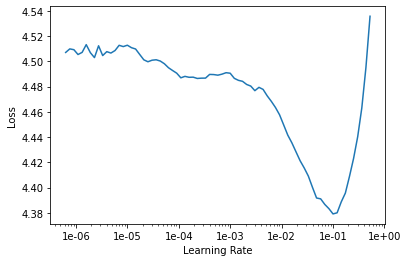

In [ ]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [ ]:
learn.fit_one_cycle(1, 1e-02)

epoch,train_loss,valid_loss,accuracy,time
0,4.267161,4.375464,0.254807,00:10


## Training

In [ ]:
learn.save_encoder('ft_enc')

### Building a classifier

In [ ]:
data_clas = TextClasDataBunch.from_csv(path, 'texts.csv', vocab=data_lm.train_ds.vocab, bs=32)
data_clas.save('data_clas_export.pkl')

In [ ]:
data_clas = load_data(path, 'data_clas_export.pkl', bs=16)

In [ ]:
data_clas.show_batch()

text,target
"xxbos xxmaj xxunk xxmaj victor xxmaj xxunk : a xxmaj review \n \n xxmaj you know , xxmaj xxunk xxmaj victor xxmaj xxunk is like sticking your hands into a big , xxunk xxunk of xxunk . xxmaj it 's warm and xxunk , but you 're not sure if it feels right . xxmaj try as i might , no matter how warm and xxunk xxmaj xxunk xxmaj",negative
"xxbos xxup the xxup shop xxup around xxup the xxup corner is one of the xxunk and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come up with",positive
"xxbos xxmaj this film sat on my xxmaj tivo for weeks before i watched it . i dreaded a self - indulgent xxunk flick about relationships gone bad . i was wrong ; this was an xxunk xxunk into the screwed - up xxunk of xxmaj new xxmaj xxunk . \n \n xxmaj the format is the same as xxmaj max xxmaj xxunk ' "" xxmaj la xxmaj ronde",positive
"xxbos xxmaj many neglect that this is n't just a classic due to the fact that it 's the first xxup 3d game , or even the first xxunk - up . xxmaj it 's also one of the first xxunk games , one of the xxunk definitely the first ) truly claustrophobic games , and just a pretty well - rounded gaming experience in general . xxmaj with graphics",positive
"xxbos i really wanted to love this show . i truly , honestly did . \n \n xxmaj for the first time , gay viewers get their own version of the "" xxmaj the xxmaj bachelor "" . xxmaj with the help of his obligatory "" hag "" xxmaj xxunk , xxmaj james , a good looking , well - to - do thirty - something has the chance",negative


In [ ]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('ft_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (799 items)
x: TextList
xxbos xxmaj in theory , films should be a form of entertainment . xxmaj while this xxunk documentaries and other experimental forms of film - making ; most movies , specially genre films , must not only tell it 's story or message , they must entertain their target audience in some way . xxmaj all this just to say that in my opinion a bad movie is not a movie with low production values or low - budget , a bad movie is one that is boring . 
 
  " xxmaj hellborn " or " xxmaj asylum of the xxmaj damned " as is known in the xxup u.s. , is a bad movie simply because it is just not involving , and xxunk boring and tiresome . xxmaj while it has a very good premise , it is just poorly developed and the mediocre acting does n't make things better . xxmaj on another hands the film probably could had been a fine or even classic b - movie , but here it is just a bad attempt at film - making . 
 
  xxmaj director xxmaj phi

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


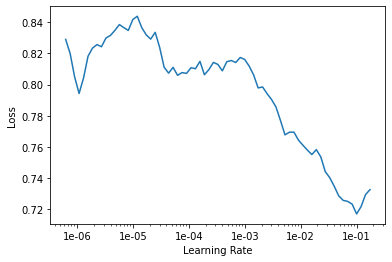

In [ ]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [ ]:
learn.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.686587,0.672039,0.597015,00:11


In [28]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.451733,0.527750,0.721393,00:11


In [30]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.408451,0.641548,0.681592,00:16


## Testing

The test contains a function called `predictToWords`. 
This function gets a sentence as input and returns `Positive` for a sentence that seems happy or `Negetive` for a sentence whose writer is mad about something. 

In [31]:
def predictToWords(sentence) :
  if learn.predict(sentence)[0]==tensor(0):
    print("Negetive")
  elif learn.predict(sentence)[0]==tensor(1):
    print("Positive")


In [42]:
predictToWords("I like it!")

Positive


##Fine Tuning

---



We imported our NLP dataset, trained a model on that dataset to find out what's the feeling behind a text, have tested our model and everything was working. Isn't it awesome?

Not yet! Now we need to improve our program to work more efficient.
To this point, our model has been trained with the last layer of the dataset.Which means more training cases will appear when we go through other layers, so the model accuracy will be improved.

In [35]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.234554,0.486415,0.791045,00:21
1,0.216888,0.481754,0.805970,00:25
2,0.197235,0.512849,0.786070,00:22
3,0.175629,0.502454,0.820895,00:22
4,0.180313,0.516187,0.805970,00:24
5,0.149978,0.507213,0.820895,00:21
6,0.129658,0.503919,0.820895,00:21
7,0.114933,0.483961,0.845771,00:21
8,0.101344,0.499828,0.840796,00:20
9,0.100795,0.519548,0.830846,00:23


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


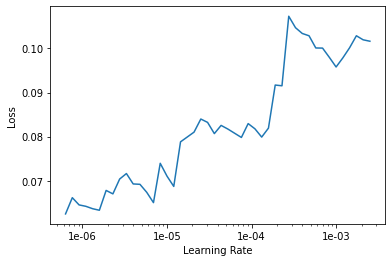

In [36]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [37]:
learn.save('fine_tuned')

In [43]:
predictToWords("The worst I ever seen!")

Negetive


In [44]:
predictToWords("It deserve every moments!")

Positive


# Your turn!

## Setup

we want to use amazon reviews data set and guess ratings by the reviews

In [ ]:
path = untar_data(URLs.AMAZON_REVIEWS)
data = pd.read_csv(path/'test.csv', header=None)

data.columns = ['rate', 'Abstract', 'review']

---

⭐ could you say why we use `data.column` ?
comment that line and see what happened to data set with using `.head()` 

---

## Data

In [ ]:
## Print the info() of the data 
### YOUR CODE HERE



In [ ]:
## Print the .head() of the data to have a quick look
### YOUR CODE HERE



In [ ]:
## show the last comment
### YOUR CODE HERE



In [ ]:
##show data group by rate column
### YOUR CODE HERE


In [ ]:
##show data group by Abstract column
### YOUR CODE HERE

## Model

Now we want to guess the abstract

In [ ]:
# Language model data
data_lm = TextLMDataBunch.from_csv(path,csvfile)
# Classifier model data
data_clas = TextClasDataBunch.from_csv(path, csvfile , vocab , Batchsize #consider 32)

In [ ]:
# save your lm data and clas data
data_lm.save('path of .pkl file')
data_clas.save('path of .pkl file')
#reload the file again with batch size 16
data_lm = load_data(path, your_data)


In [ ]:
#Fine-tuning a language model and weight 0.3
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult)

# unfreeze it and fit one cycle

learn.fit_one_cycle(1, 1e-2)


#make a prediction with a movie
learn.predict(sentence)

⭐ better to write a function to inpret the prediction 

# Summary